## Реализация StyleGAN-NADA

Клонируем эталонную реализацию StyleGAN2 для PyTorch

In [13]:
# !pip install ftfy regex tqdm matplotlib

In [14]:
# !pip install git+https://github.com/openai/CLIP.git

In [15]:
import pickle
from typing import Iterable
from itertools import islice

import clip
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
import torchvision.utils as tvutils
import matplotlib.pyplot as plt
# from tqdm import tqdm

from tqdm.notebook import tqdm

# import topilimage
from torchvision.transforms import ToPILImage

In [16]:
!nvidia-smi

Sat Feb  1 14:02:44 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti     On  | 00000000:A1:00.0 Off |                  N/A |
| 31%   26C    P2              30W / 285W |   2899MiB / 12282MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [17]:
to_pil = ToPILImage()

In [18]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

device

device(type='cuda')

In [19]:
# !git clone https://github.com/NVlabs/stylegan2-ada-pytorch stylegan

In [20]:
# %conda install pytorch click requests tqdm pyspng ninja imageio-ffmpeg==0.4.3 torchvision torchaudio -c pytorch -c nvidia
# !pip install git+https://github.com/openai/CLIP.git

In [21]:
# !wget -P /stylegan/pretrained https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
# !wget -P /stylegan/pretrained https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metfaces.pkl

#### Загрузка моделей

In [22]:
CLIP_MODEL = "ViT-B/32"
# CLIP_MODEL = "ViT-L/14@336px"
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [23]:
clip_model, clip_preprocess = clip.load(CLIP_MODEL, device=device)
clip_model.eval();

In [24]:
import sys
import importlib

sys.path.insert(0, "/stylegan")

if "torch_utils" in sys.modules:
    del sys.modules["torch_utils"]

torch_utils = importlib.import_module("torch_utils")

In [25]:
# with open("/stylegan/pretrained/metfaces.pkl", "rb") as f:
with open("/stylegan/pretrained/ffhq.pkl", "rb") as f:
    stylegan = pickle.load(f)

frozen_generator = stylegan["G_ema"].to(device)
frozen_generator.eval()
trained_generator = stylegan["G"].to(device)
trained_generator.train()
for param in trained_generator.parameters():
    param.requires_grad = True

print(f"{frozen_generator.training=}, {trained_generator.training=}")

frozen_generator.training=False, trained_generator.training=True


In [26]:
INDEX_TO_LAYERS = {
    0: "b4.conv1",
    1: "b8.conv0",
    2: "b8.conv1",
    3: "b16.conv0",
    4: "b16.conv1",
    5: "b32.conv0",
    6: "b32.conv1",
    7: "b64.conv0",
    8: "b64.conv1",
    9: "b128.conv0",
    10: "b128.conv1",
    11: "b256.conv0",
    12: "b256.conv1",
    13: "b512.conv0",
    14: "b512.conv1",
    15: "b1024.conv0",
    16: "b1024.conv1",
    17: None,
}

In [27]:
def set_trainable_layers(generator: nn.Module, trainable_layer_indices: Iterable[int]):
    layers_to_train = []
    for idx in trainable_layer_indices:
        if layer_name := INDEX_TO_LAYERS.get(idx):
            layers_to_train.append(f"synthesis.{layer_name}")

    for param_name, param in generator.named_parameters():
        param.requires_grad = False
        for layer_name in layers_to_train:
            if param_name.startswith(layer_name) and "affine" not in param_name:
                param.requires_grad = True
                break

    print("Generator trainable layers:\n")
    for param_name, param in generator.named_parameters():
        if param.requires_grad:
            print(param_name)

In [28]:
import os, gc

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["TORCH_CUDA_ARCH_LIST"] = "8.9"

In [29]:
torch.cuda.empty_cache()
gc.collect()

92

In [30]:
# batch_size = 2

# z = torch.randn(batch_size, trained_generator.z_dim, device=device)
# ws = trained_generator.mapping(z, None)
# generated_images = trained_generator.synthesis(ws, noise_mode="const")  # [B, 3, H, W]

# # Plot the first image in the batch (convert from [-1,1] to [0,1])
# img = generated_images[0]
# img_disp = (img + 1.0) * 0.5
# pil_img = to_pil(img_disp.cpu())
# plt.figure(figsize=(5, 5))
# plt.imshow(pil_img)
# plt.axis("off")
# plt.show()

# # Preprocess the batch for CLIP
# clip_images = []
# for i in range(batch_size):
#     pil_img = to_pil(((generated_images[i] + 1.0) * 0.5).cpu())
#     clip_img = clip_preprocess(pil_img)  # [3, 224, 224]
#     clip_images.append(clip_img)
# clip_preprocessed_images = torch.stack(clip_images).to(device)  # [B, 3, 224, 224]

# # Use the CLIP model to encode the images
# features = clip_model.encode_image(clip_preprocessed_images)
# print("CLIP image features shape:", features.shape)

In [31]:
# features.mean(0).shape

In [32]:
# text_token = clip.tokenize("kiss makeup").to(device)
# type(clip_model.encode_text(text_token))

In [33]:
def clip_loss(image: torch.Tensor, text_embedding: torch.Tensor) -> torch.Tensor:
    image_embed = clip_model.encode_image(image).mean(0)
    return 1 - torch.cosine_similarity(image_embed, text_embedding, dim=-1)

In [34]:
def get_active_layer_indices(
    text, batch_size: int = 4, num_epochs: int = 16, num_indices: int = 4
) -> list[int]:
    print("Determining active layers...")
    z = torch.randn(batch_size, frozen_generator.z_dim, device=device)
    with torch.no_grad():
        latent = frozen_generator.mapping(z, None)

    initial_latent = latent.detach().clone()
    latent.requires_grad = True

    with torch.no_grad():
        tokenized_text = clip.tokenize(text).to(device)
        text_embedding = clip_model.encode_text(tokenized_text)

    optimizer = torch.optim.Adam([latent], lr=0.08)
    # torch.cuda.empty_cache()
    for _ in tqdm(range(num_epochs)):
        generated_images = frozen_generator.synthesis(latent, noise_mode="const")

        clip_images = []
        for i in range(batch_size):
            normalized_img = (generated_images[i] + 1.0) * 0.5
            pil_img = to_pil(normalized_img.cpu())
            clip_img = clip_preprocess(pil_img)
            clip_images.append(clip_img)

        clip_preprocessed_images = torch.stack(clip_images).to(device)  # [B, 3, 224, 224]

        img_clip_loss = clip_loss(clip_preprocessed_images, text_embedding)

        img_clip_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    latent_delta = (latent - initial_latent).abs().mean(dim=(0, 2))
    sorted_indices = torch.argsort(latent_delta, descending=True)
    layer_indices = sorted_indices[:num_indices].tolist()

    return layer_indices

In [35]:
NUM_LAYER_INDICES = 12

In [36]:
SOURCE_TEXT = "photo"
TARGET_TEXT = "painting"
# TARGET_TEXT = "kiss makeup"
# TARGET_TEXT = "light wrinkes" 5d05ec9ebd63f722dc1e3ff86fb646ee71f4f92695ee4ab4e5ca1eac72158e45

In [37]:
def freeze_layers(generator: nn.Module, num_indices: int = NUM_LAYER_INDICES):
    active_layer_indices = get_active_layer_indices(
        TARGET_TEXT, num_epochs=32, num_indices=num_indices
    )
    set_trainable_layers(generator, active_layer_indices)

In [38]:
def get_images_clip_embedding(images: torch.Tensor) -> torch.Tensor:
    clip_images = []
    for i in range(images.size(0)):
        normalized_img = (images[i] + 1.0) * 0.5
        pil_img = to_pil(normalized_img.cpu())
        clip_img = clip_preprocess(pil_img)
        clip_images.append(clip_img)

    clip_preprocessed_images = torch.stack(clip_images).to(device)
    clip_embedding = clip_model.encode_image(clip_preprocessed_images)

    return clip_embedding

In [39]:
def compute_directional_loss(trained_images, frozen_images, text_delta, alpha=1.0):
    train_embeddings = get_images_clip_embedding(trained_images)
    frozen_embeddings = get_images_clip_embedding(frozen_images)
    image_delta = (train_embeddings - frozen_embeddings).mean(dim=0).unsqueeze(0)

    cos_sim = F.cosine_similarity(image_delta, text_delta).mean(dim=0)
    directional_loss = alpha * (1 - cos_sim)

    return directional_loss

#### Обучение

In [40]:
def train_nada(
    source_text,  # Текст, описывающий исходный домен
    target_text,  # Текст, описывающий целевой стиль/домен
    num_epochs=100,
    batch_size=2,
    lr=0.002,
    num_indices=NUM_LAYER_INDICES,
):
    with torch.no_grad():
        target_token = clip.tokenize(target_text).to(device)
        source_token = clip.tokenize(source_text).to(device)
        target_embedding = clip_model.encode_text(target_token)
        source_embedding = clip_model.encode_text(source_token)

    text_delta = target_embedding - source_embedding

    freeze_layers(trained_generator, num_indices=num_indices)
    trainable_params = [param for param in trained_generator.parameters() if param.requires_grad]
    optimizer = torch.optim.Adam(trainable_params, lr=lr)

    for epoch in tqdm(range(num_epochs)):
        z = torch.randn(batch_size, trained_generator.z_dim, device=device)
        ws = trained_generator.mapping(z, None)

        trained_images = trained_generator.synthesis(ws, noise_mode="const")
        with torch.no_grad():
            frozen_images = frozen_generator.synthesis(ws, noise_mode="const")

        loss = compute_directional_loss(trained_images, frozen_images, text_delta)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{num_epochs}   Loss: {loss.item():.4f}")
            with torch.no_grad():
                fake_img_grid = tvutils.make_grid(trained_images[:3], padding=8, normalize=True)
                plt.imshow(fake_img_grid.permute(1, 2, 0).cpu())
                plt.axis("off")
                plt.show()

        del z, ws, trained_images, frozen_images
        torch.cuda.empty_cache()

Determining active layers...
Setting up PyTorch plugin "bias_act_plugin"... Done.


  0%|          | 0/32 [00:00<?, ?it/s]

Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Generator trainable layers:

synthesis.b4.conv1.weight
synthesis.b4.conv1.noise_strength
synthesis.b4.conv1.bias
synthesis.b8.conv0.weight
synthesis.b8.conv0.noise_strength
synthesis.b8.conv0.bias
synthesis.b8.conv1.weight
synthesis.b8.conv1.noise_strength
synthesis.b8.conv1.bias
synthesis.b16.conv0.weight
synthesis.b16.conv0.noise_strength
synthesis.b16.conv0.bias
synthesis.b16.conv1.weight
synthesis.b16.conv1.noise_strength
synthesis.b16.conv1.bias
synthesis.b32.conv0.weight
synthesis.b32.conv0.noise_strength
synthesis.b32.conv0.bias
synthesis.b1024.conv1.weight
synthesis.b1024.conv1.noise_strength
synthesis.b1024.conv1.bias


  0%|          | 0/101 [00:00<?, ?it/s]

Epoch 0/101   Loss: 0.9609


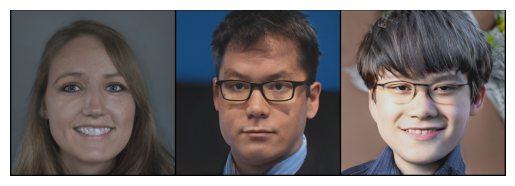

Epoch 10/101   Loss: 1.0381


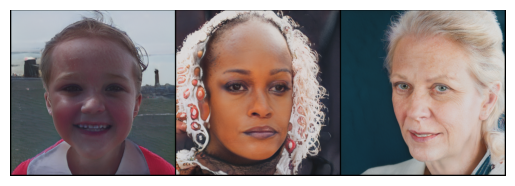

Epoch 20/101   Loss: 0.9141


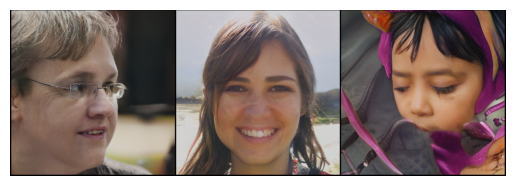

Epoch 30/101   Loss: 0.9058


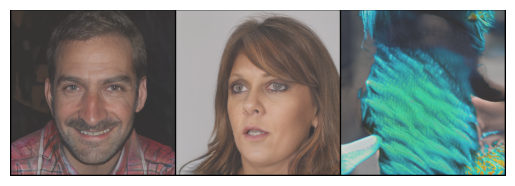

Epoch 40/101   Loss: 0.9575


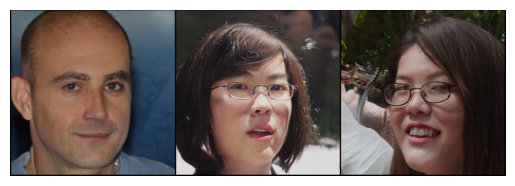

Epoch 50/101   Loss: 1.0010


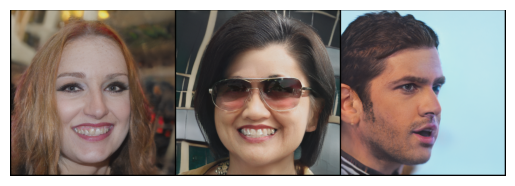

Epoch 60/101   Loss: 0.9741


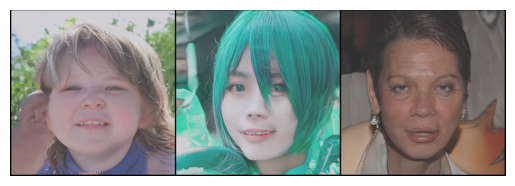

Epoch 70/101   Loss: 0.9492


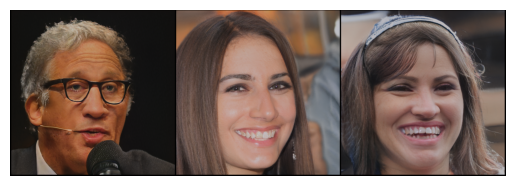

Epoch 80/101   Loss: 1.0469


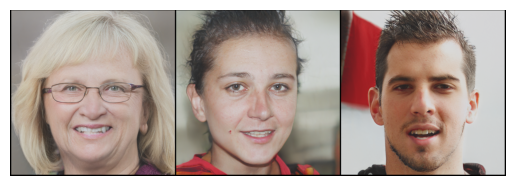

Epoch 90/101   Loss: 0.9131


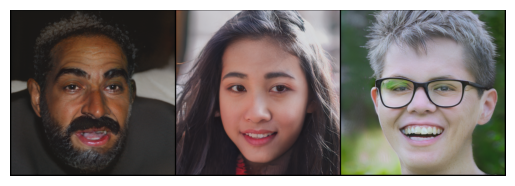

Epoch 100/101   Loss: 0.9678


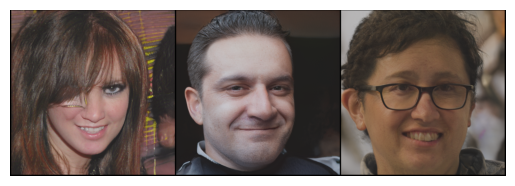

In [41]:
train_nada(
    SOURCE_TEXT,
    TARGET_TEXT,
    num_epochs=101,
    batch_size=5,
    # lr=0.1,
    # lr=0.01,
    lr=0.0005,
    num_indices=8,
)

In [42]:
torch.cuda.empty_cache()
gc.collect()

5704